6/23/2022

Test simulation on CaOH bending mode microwave spectrum.

In [1]:
using Revise

In [2]:
# using MKL
using JuliaSpectra
using BenchmarkTools
using Parameters
using Plots, PrettyTables
plotlyjs()
using LinearAlgebra, StructArrays
BLAS.get_config()
;

┌ Info: Precompiling JuliaSpectra [3ef6d832-bae6-4172-b279-153036e5bc42]
└ @ Base loading.jl:1423


WebIO._IJuliaInit()

In [3]:
const sol = 29979.2458 # converts cm-1 to MHz.
const h = 6.626e-34
const ħ = h / 2π
const μB = 4.66989733e-5 * sol # in MHz/Gauss.
;

In [4]:
@unpack B, γ, bF, c, qv, gS = MolParams["CaOH"]["X010"]
const BX = B*sol
const γX = γ*sol
const bFX = bF*sol
const cX = c*sol
const qvX = qv*sol
const gSX = gS
;

In [5]:
# Build N=1
boundsN1 = (l=[-1,1], I=1/2, N=1, Λ=0, S = 1/2)
basisN1 = enumerate_states(LinearCaseB_Bend_Field, boundsN1)

boundsN2 = (l=[-1,1], I=1/2, N=2, Λ=0, S = 1/2)
basisN2 = enumerate_states(LinearCaseB_Bend_Field, boundsN2)
;


Simulate microwave spectrum with option to select a single starting $F$ level and the option to turn on a B-field.

In [6]:
N1 = makevibronicmanifold(basisN1, [(BX, Rotation),(γX,SpinRotation),(bFX+cX/3, HyperfineFermi),(cX,Hyperfine_Dipolar_c),(qvX,lDoubling),(0.0,μB*gSX*Zeeman)])
N2 = makevibronicmanifold(basisN2, [(BX, Rotation),(γX,SpinRotation),(bFX+cX/3, HyperfineFermi),(cX,Hyperfine_Dipolar_c),(qvX,lDoubling),(0.0,μB*gSX*Zeeman)])

TDMvibro = makeTDMvibronicmanifolds(N1,N2)

xplot = []
yplot = []
for (i,Bfield)  in enumerate(range(2.6, stop=2.6, length=1))
    N1.prefactors[6] = Bfield
    N2.prefactors[6] = Bfield 
    xdict, xccs = makeblockedvibronicmanifold(N1)
    adict, accs = makeblockedvibronicmanifold(N2)
    blockTDMDict = makeblockedTDMDict(xccs,accs,TDMvibro)
    lout2 = makeLineList(xdict, adict, blockTDMDict, [-1.0,0.1,1]; TK=500)
    # Select only the F=0 lower levels:
    filter_rule(x) = x.lower.basis[argmax(abs.(x.lower.coeffs))].F == 0 ? true : false
    lfilt = filter_transitions(lout2, filter_rule)
    x,y=plotLineList(lfilt, 39914.0, 39920, gamma=0.15, nstep=3000)
    push!(xplot,x .- 39820)
    push!(yplot,y/4 .+Bfield)
end
plot(reduce(hcat,xplot),reduce(hcat,yplot),lw=2)
xlabel!("Frequency (MHz)")
ylabel!("Intensity [offset = B in Gauss]")
plot!(legend=false, title="CaOH X(010) N=1-N=2 Zeeman, F''=0 only", frame=:box, margin=5*Plots.PlotMeasures.mm)

### Work on labeling of transitions in linelist.
Simulat the zero-field microwave spectrum and label lines by (J,F,parity).

In [7]:
function label_rule(t::Transition)
    Pop=build(Hamiltonian(basis=t.lower.basis, H_operator=parity))
    p = round(t.lower.coeffs' * Pop * t.lower.coeffs, digits=1)
    if p == 1.0
        plab1 = "+"
    elseif p == -1.0
        plab1 = "-"
    else 
        plab1 = " "
    end
    label1 = string("J=",t.lower.basis[argmax(abs.(t.lower.coeffs))].J, " F=",t.lower.basis[argmax(abs.(t.lower.coeffs))].F, " p=",plab1)

    Pop=build(Hamiltonian(basis=t.upper.basis, H_operator=parity))
    p = round(t.upper.coeffs' * Pop * t.upper.coeffs, digits=1)
    if p == 1.0
        plab2 = "+"
    elseif p == -1.0
        plab2 = "-"
    else 
        plab2 = " "
    end
    label2 = string("J=",t.upper.basis[argmax(abs.(t.upper.coeffs))].J, " F=",t.upper.basis[argmax(abs.(t.upper.coeffs))].F, " p=",plab2)
    return string("(",label2,") <- (", label1,")")
end

label_rule (generic function with 1 method)

In [8]:
# Try outputting a linelist structure.
N1.prefactors[6] = 0
N2.prefactors[6] = 0
xdict, xccs = makeblockedvibronicmanifold(N1)
adict, accs = makeblockedvibronicmanifold(N2)
blockTDMDict = makeblockedTDMDict(xccs,accs,TDMvibro)
lout2 = makeLineList(xdict, adict, blockTDMDict, [-0.9, 0.1, 0.9]; TK=500000)
label_transitions!(lout2, label_rule)
;

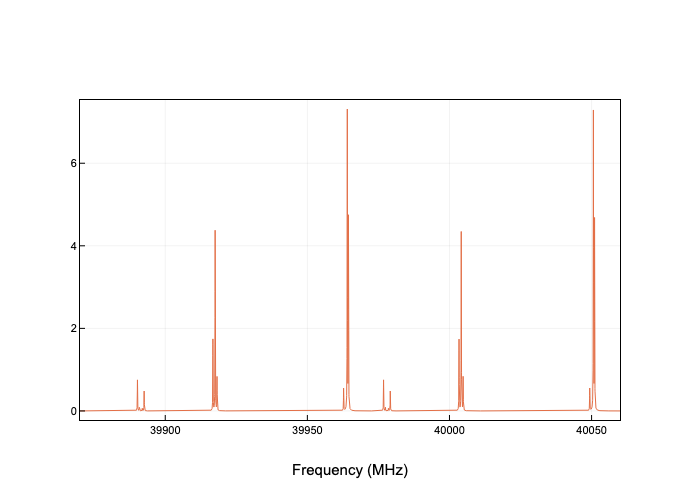

In [9]:
ph=plotLineList(lout2,39870., 40060.0, gamma = 0.1, nstep=15_000, make_plot=true)
PlotlyJS.relayout(Plots.plotlyjs_syncplot(ph), hovermode="x", margin=1*Plots.PlotMeasures.mm)

### Test a method to filter the linelist according to certain conditions
For example, try to plot only transitions coming from the $(J=1/2, F=0)$ components.

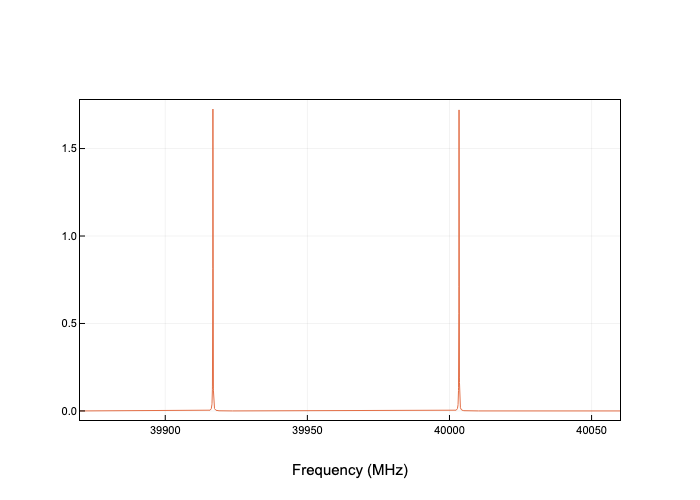

In [10]:
filter_rule(x) = x.lower.basis[argmax(abs.(x.lower.coeffs))].F == 0 ? true : false

lfilt = filter_transitions(lout2, filter_rule)
ph=plotLineList(lfilt,39870., 40060; gamma = 0.1, nstep=15_000, make_plot=true)
PlotlyJS.relayout(Plots.plotlyjs_syncplot(ph), hovermode="x", hoverdistance=10,  margin=0)

Filter on transition strength.

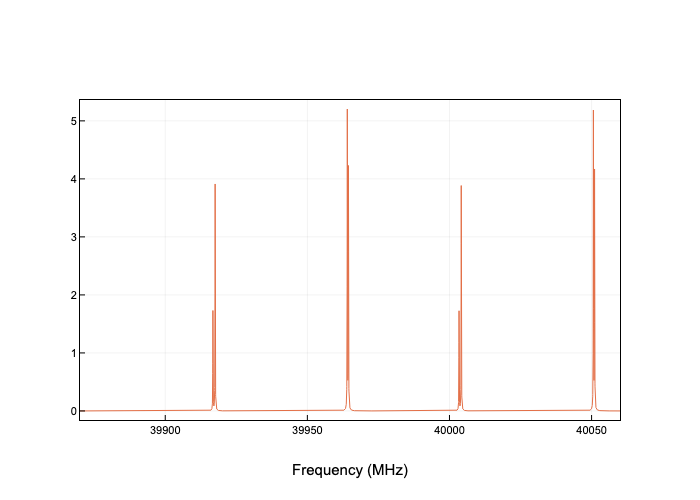

In [117]:
filter_rule(x) = x.intensity > 0.1 ? true : false

lfilt = filter_transitions(lout2, filter_rule)
ph=plotLineList(lfilt,39870., 40060; gamma = 0.1, nstep=15_000, make_plot=true)
PlotlyJS.relayout(Plots.plotlyjs_syncplot(ph), hovermode="x", hoverdistance=10,  margin=0)

In [118]:
@time LineList_tabular(lfilt; offset = 39000.0)

┌────────────────────────────────────────────┬──────────────────┬───────────┐
│                 Transition                 │    Frequency     │ Intensity │
│                                            │  - 39000.0 (MHz) │  (arb.)   │
├────────────────────────────────────────────┼──────────────────┼───────────┤
│ (J=3//2 F=1//1 p=+) <- (J=1//2 F=0//1 p=-) │      916.8       │   0.135   │
│ (J=3//2 F=1//1 p=+) <- (J=1//2 F=0//1 p=-) │      916.8       │   0.135   │
│ (J=3//2 F=2//1 p=+) <- (J=1//2 F=1//1 p=-) │      917.5       │   0.102   │
│ (J=3//2 F=2//1 p=+) <- (J=1//2 F=1//1 p=-) │      917.5       │   0.102   │
│ (J=3//2 F=2//1 p=+) <- (J=1//2 F=1//1 p=-) │      917.5       │   0.205   │
│ (J=3//2 F=2//1 p=+) <- (J=1//2 F=1//1 p=-) │      917.5       │   0.205   │
│ (J=5//2 F=3//1 p=+) <- (J=3//2 F=2//1 p=-) │      964.0       │   0.243   │
│ (J=5//2 F=3//1 p=+) <- (J=3//2 F=2//1 p=-) │      964.0       │   0.243   │
│ (J=5//2 F=3//1 p=+) <- (J=3//2 F=2//1 p=-) │      964.0       